In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math

500


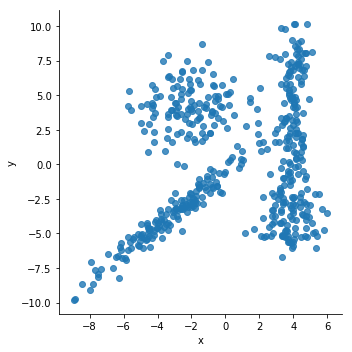

In [2]:
Data = pd.read_csv('Data/EMGaussian.data',sep=" ", names=["x","y"])
Test = pd.read_csv('Data/EMGaussian.test',sep=" ", names=["x","y"])
print(len(Data))
sns.lmplot( x='x', y='y', data = Data, fit_reg=False)

In [3]:
# number of Clusters 
K = 4
def ComputeDistance(distance, data, centers):
    if distance == 'L2':
        for k in range( K ):
            data[k] = (data[['x', 'y']] - centers[k]).pow(2).sum(1)
    elif distance == 'L1':
        for k in range( K ):
            data[k] = (data[['x', 'y']] - centers[k]).abs().sum(1)
    elif distance == 'Linf':
        for k in range( K ):
            data[k] = (data[['x', 'y']] - centers[k]).abs().max(1)
    else:
        raise( NotImplementedError)
    data['closest'] = data[list(range(K))].idxmin(axis=1)
def updateDistanceAndCenters(distance, data, centers):
    ComputeDistance(distance, data, centers)
    return [ np.array(data.loc[data.closest == k][['x','y']].mean()) for k in range(K)]


[array([-3.53755378, -3.96508153]),
 array([3.78809286, 4.99905357]),
 array([ 3.643406  , -2.87254143]),
 array([-2.21737765,  4.20941424])]

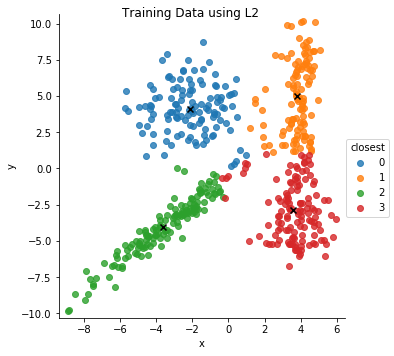

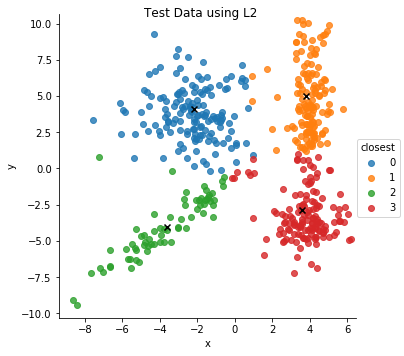

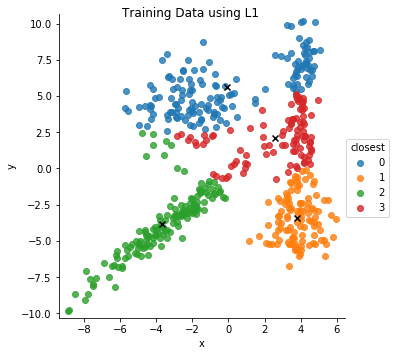

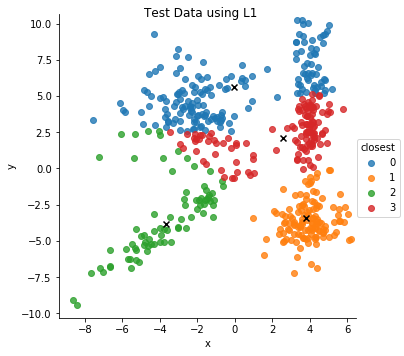

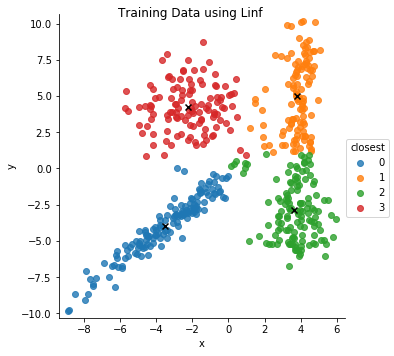

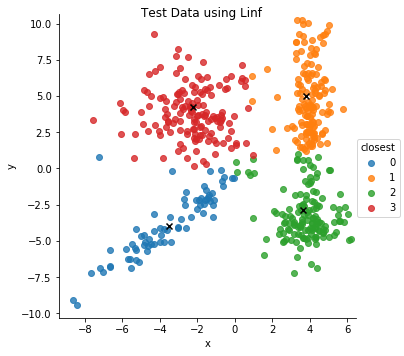

In [17]:
def K_means(distance, data, centers):
    iterations = 0
    old = [ np.array([0,0])]*4
    while sum( np.linalg.norm(old[k] - centers[k]) for k in range(K)) > 0.01:
        old = centers
        centers = updateDistanceAndCenters(distance, data, centers)
        iterations += 1
    return iterations, centers

def CalibratePredictPlot( distance ):
    #random initiation
    xrange = (Data['x'].min()-0.5, Data['x'].max()+0.5)
    yrange = (Data['y'].min()-0.5, Data['y'].max()+0.5)
    centers = [np.array(Data[['x','y']].loc[ np.random.randint(500)]) for i in range(K)]
    _, centers = K_means(distance, Data, centers)  
    ComputeDistance(distance, Test, centers)
    sns.lmplot( x='x', y='y', data = Data, fit_reg=False, hue = 'closest').fig.suptitle("Training Data using "+ distance, fontsize=12)
    centers_x = [ i[0] for i in centers]
    centers_y = [ i[1] for i in centers]
    plt.scatter(centers_x, centers_y, color = 'black', marker ='x', linewidths = 1.5)
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.savefig("Kmeans_tain" + distance +".pdf")
    sns.lmplot( x='x', y='y', data = Test, fit_reg=False, hue = 'closest').fig.suptitle("Test Data using "+ distance, fontsize=12)
    plt.scatter(centers_x, centers_y, color = 'black', marker ='x', linewidths = 1.5)
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.savefig("Kmeans_test" + distance +".pdf")
    return centers
CalibratePredictPlot('L2')
CalibratePredictPlot('L1')
CalibratePredictPlot('Linf')

In [5]:
def convergence(distance):
    iteration_list = []
    for j in range(100):
        centers = [np.array(Data[['x','y']].loc[ np.random.randint(500)]) for i in range(K)]
        iteration_list.append( K_means(distance, Data, centers)[0] )
    return np.mean(iteration_list), max(iteration_list), min(iteration_list)


In [6]:
DF = pd.DataFrame()
for d in ['L1', 'L2', 'Linf']:
    for col, value in zip(['Mean', 'Max', 'Min'], convergence(d)):
        DF.loc[ d , col ] =  value

In [7]:
DF

,Mean,Max,Min
L1,15.70,38.0,1.0
L2,12.45,29.0,1.0
Linf,10.95,25.0,4.0


In [8]:
centers = [np.array(Data[['x','y']].loc[ np.random.randint(500)]) for i in range(K)]
centers = K_means('L2', Data, centers)[1] 
sigma = [1] * 4
Membershipweight = np.array([0.25] * 4)
def Mstep(data, Centers, Sigma, membershipweight): 
    for k in range(K):
        data['weight' + str(k) ] = np.exp( - 0.5 * data[k] / ( Sigma[k] ** 2 ) ) /( 2 * np.pi *  Sigma[k] ** 4 )
    data[ ['weight' + str(k)  for k in range( K ) ]] = data[ ['weight' + str(k)  for k in range( K ) ]] * membershipweight
    data[ ['weight' + str(k)  for k in range( K ) ]] = data[ ['weight' + str(k)  for k in range( K ) ]].div(data[ ['weight' + str(k)  for k in range( K ) ] ].sum(axis=1), axis=0)

def Estep(data, Centers, Sigma, membershipweight ):    
    newWeight = np.array(data[['weight' + str(k)  for k in range( K ) ]].sum() / len( data ) )
    for k in range(K):
        Centers[k] = np.average( data[ [ 'x', 'y' ] ], weights = data[ 'weight' + str(k)], axis = 0)
        data[k] = (data[['x', 'y']] - Centers[k]).pow(2).sum(1)
        Sigma[k]= np.sqrt( np.average( data[ k ], weights = data[ 'weight' + str(k)], axis = 0))
        membershipweight[k] = newWeight[k]

In [9]:
def EM_Calibrator(data, Centers, Sigma, membershipweight):
    iterations = 0
    old = [ np.array([0,0])]*4
    while sum( np.linalg.norm(old[k] - Centers[k]) for k in range(K)) > 0.00001:
        old = Centers
        Mstep(data, Centers, Sigma, membershipweight)
        Estep(data, Centers, Sigma, membershipweight)
        iterations += 1
    return iterations

print(centers, sigma, Membershipweight)
print(EM_Calibrator(Data, centers, sigma, Membershipweight))
print(centers, sigma, Membershipweight)


[array([-2.23856221,  4.16339661]), array([3.80280826, 5.10467248]), array([ 3.36449672, -2.65646983]), array([-3.78479953, -4.21639713])] [1, 1, 1, 1] [0.25 0.25 0.25 0.25]
1
[array([-2.22388801,  4.13621777]), array([3.78801476, 5.103813  ]), array([ 3.38273207, -2.67593058]), array([-3.7734817, -4.2080201])] [2.247931562555436, 2.602606711083103, 2.508819384006731, 2.8104145811619214] [0.23871492 0.21879698 0.28382888 0.25865922]


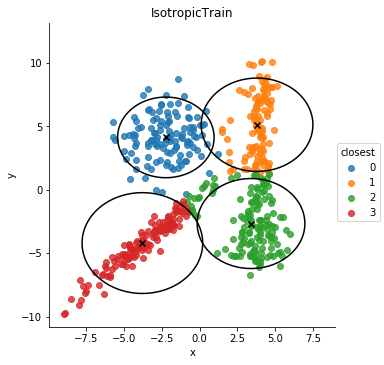

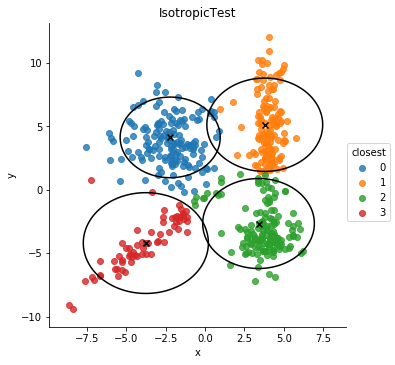

In [26]:
def isotropicplot(data, Centers, Sigma, name):
    xrange = (Data['x'].min()-1, Data['x'].max()+3)
    yrange = (Data['y'].min()-1, Data['y'].max()+3)
    Centers_x = [ i[0] for i in Centers]
    Centers_y = [ i[1] for i in Centers]
    for k in range(K):
        data[k] = (data[['x', 'y']] - Centers[k]).pow(2).sum(1)
        data['weight' + str(k) ] = np.exp( - 0.5 * data[k] / ( Sigma[k] ** 2 ) ) /( 2 * np.pi *  Sigma[k] ** 4 )
    data['closest'] = [ x[-1] for x in data[['weight' + str(k)  for k in range( K ) ]].idxmax(axis=1)]
    sns.lmplot( x='x', y='y', data = data,hue = 'closest', fit_reg = False)
    plt.scatter(Centers_x, Centers_y, color = 'black', marker ='x', linewidths = 1.5)

    plt.xlim(xrange)
    plt.ylim(yrange)
    yRange = ( data['y'].min()*2, data['y'].max()*2 )
    xRange = ( data['x'].min()*2, data['x'].max()*2 )
    
    x = np.linspace(xRange[0], xRange[1], 400)
    y = np.linspace(*yRange, 400)
    x, y = np.meshgrid(x, y)
    for k in range(K):
        plt.contour(x, y, (x - Centers_x[k])**2 +  (y - Centers_y[k]) ** 2 - 2*Sigma[k]**2, [0],colors = 'k' )

    plt.title('Isotropic'+ name)
    plt.savefig('Isotropic'+ name +'.pdf')
isotropicplot(Data, centers, sigma, 'Train')
isotropicplot(Test, centers, sigma, 'Test')

In [12]:
def isotropicLikelyhood(data, Centers, Sigma, membershipweight):
    for k in range(K):
        data[k] = (data[['x', 'y']] - Centers[k]).pow(2).sum(1)
        data['weight' + str(k) ] = np.exp( - 0.5 * data[k] / ( Sigma[k] ** 2 ) ) /( 2 * np.pi *  Sigma[k] ** 4 )
    data[ ['weight' + str(k)  for k in range( K ) ]] = data[ ['weight' + str(k)  for k in range( K ) ]] * membershipweight
    return np.sum(np.log(data[ ['weight' + str(k)  for k in range( K ) ] ].sum(axis = 1)))
isotropicLikelyhood(Data, centers, sigma, Membershipweight),isotropicLikelyhood(Test,  centers, sigma, Membershipweight)

(-3643.3686184446256, -3621.502709502135)

[array([-2.21944606,  4.13337723]), array([3.79113575, 5.13091135]), array([ 3.39416554, -2.660414  ]), array([-3.76669578, -4.20114012])]
[array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]])]
1
[array([-2.21947108,  4.1334507 ]), array([3.79116206, 5.13120346]), array([ 3.39412829, -2.66014943]), array([-3.76669495, -4.20112896])]
[array([[5.36096447e-01, 3.03352093e-04],
       [3.03352093e-04, 6.75572320e-01]]), array([[0.134198  , 0.10144729],
       [0.10144729, 1.32261152]]), array([[ 0.58994562, -0.22368743],
       [-0.22368743,  1.20666245]]), array([[1.00757595, 0.97812654],
       [0.97812654, 1.04632114]])]


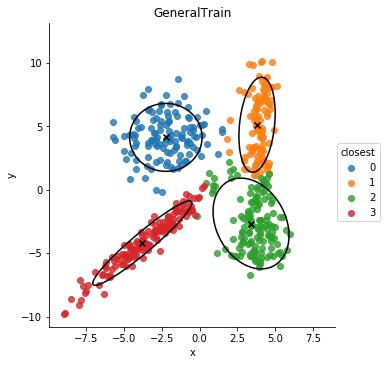

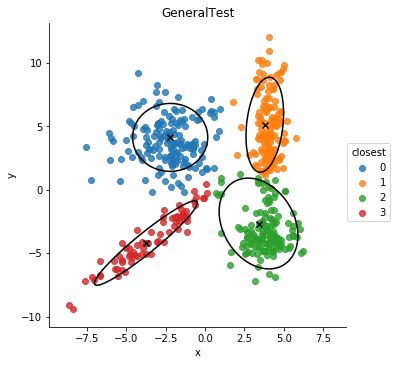

In [27]:
membershipweight = 1
general_Sigma = [ np.array( [[1,0], [0,1]]) for k in range(K)]


def weight(data,General_Sigma, Centers,  k ):
    input_array= data[['x','y']]
    temp = input_array.copy()
    temp['x'] = temp['x'] - Centers[k][0]
    temp['y'] = temp['y'] - Centers[k][1]
    return np.exp( - 0.5 * np.einsum('ij,ij->i', np.dot(temp, np.linalg.inv(General_Sigma[k])), temp))/  (2 * np.pi * np.sqrt( np.linalg.det(General_Sigma[k]) ))

def Global_Mstep(data, General_Sigma, Centers, membershipweight):
    for k in range( K ):
        data['weight' + str(k) ] =  weight(data,General_Sigma, Centers,  k )
    data[ ['weight' + str(k)  for k in range( K ) ]] = data[ ['weight' + str(k)  for k in range( K ) ]] * membershipweight
    data[ ['weight' + str(k)  for k in range( K ) ]] = data[ ['weight' + str(k)  for k in range( K ) ]].div(data[ ['weight' + str(k)  for k in range( K ) ] ].sum(axis=1), axis=0)       

def Global_Estep(data, General_Sigma, Centers, membershipweight):
    newWeight = np.array(data[['weight' + str(k)  for k in range( K ) ]].sum() / len( data ) )
    input_array= data[['x','y']]
    for k in range(K):
        Centers[k] = np.average( input_array, weights = data[ 'weight' + str(k)], axis = 0)
        temp = input_array.copy()
        temp['x'] = temp['x'] - Centers[k][0]
        temp['y'] = temp['y'] - Centers[k][1]
        General_Sigma[k] = np.dot(temp.T, (data['weight' + str(k)] * temp.T).T) / len(data)
        membershipweight[k] = newWeight[k]
                  
def EM_GlobalCalibrator(data, General_Sigma, Centers, membershipweight):
    iterations = 0
    old = [ np.array([10,10])]*4
    while max( np.linalg.norm(old[k] - Centers[k]) for k in range(K)) > 0.01:
        old = Centers
        Global_Mstep(data, General_Sigma, Centers, membershipweight)
        Global_Estep(data, General_Sigma, Centers, membershipweight)
        iterations += 1
    return iterations
print(centers)
print(general_Sigma)
print(EM_GlobalCalibrator(Data, general_Sigma, centers, Membershipweight))
print(centers)
print(general_Sigma)
def EMPlot(data, General_Sigma, Centers, name):
    xrange = (Data['x'].min()-1, Data['x'].max()+3)
    yrange = (Data['y'].min()-1, Data['y'].max()+3)
    Centers_x = [ i[0] for i in Centers]
    Centers_y = [ i[1] for i in Centers]
    for k in range( K ):
        data['weight' + str(k) ] =  weight(data,General_Sigma, Centers,  k )
    data['closest'] = [ x[-1] for x in data[['weight' + str(k)  for k in range( K ) ]].idxmax(axis=1)]
    sns.lmplot( x='x', y='y', data = data,hue = 'closest', fit_reg = False)

    plt.scatter(Centers_x, Centers_y, color = 'black', marker ='x', linewidths = 1.5)
    plt.xlim(xrange)
    plt.ylim(yrange)
    yRange = ( data['y'].min()*2, data['y'].max()*2 )
    xRange = ( data['x'].min()*2, data['x'].max()*2 )
    x = np.linspace(xRange[0], xRange[1], 400)
    y = np.linspace(*yRange, 400)
    x, y = np.meshgrid(x, y)

    for k in range(K):
        Inverse = np.linalg.inv(General_Sigma[k])
        a, b, c = Inverse[0][0], Inverse[1][0]+ Inverse[0][1], Inverse[1][1]
        plt.contour(x, y, a*(x - Centers_x[k])**2 +  c*(y - Centers_y[k]) ** 2 + b* (x - Centers_x[k])* (y - Centers_y[k])-10.62, [0],colors = 'k' )
    plt.title('General'+ name )
    plt.savefig('General'+ name + '.pdf')
EMPlot(Data, general_Sigma, centers, 'Train')
EMPlot(Test, general_Sigma, centers, 'Test')

In [14]:
def GeneralLikeyhood(data, General_Sigma, Centers, membershipweight  ):
    for k in range( K ):
        data['weight' + str(k) ] =  weight(data,General_Sigma, Centers,  k )
    data[ ['weight' + str(k)  for k in range( K ) ]] = data[ ['weight' + str(k)  for k in range( K ) ]] * membershipweight
    return np.sum(np.log(data[ ['weight' + str(k)  for k in range( K ) ] ].sum(axis = 1)))
GeneralLikeyhood(Data,  general_Sigma, centers, Membershipweight ),GeneralLikeyhood(Test,  general_Sigma, centers, Membershipweight )


(-3103.9787959195055, -3304.761564566184)